In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, mean_absolute_error
%matplotlib inline 

In [3]:
# color dict (use: colors['XColor'])
import ast
with open('color_palette.txt', 'r') as file:
    contents = file.read()
    colors = ast.literal_eval(contents)

In [7]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'

In [4]:
dets = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
csv_end = '_mimic_mll.csv'
# for dataframes
algcol = ['knn_auto', 'dtree_auto', 'knn31', 'dtree31', 'knn113', 'dtree113']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']
tfrac = '_tset1.0_'
# copied from htc_prep
fracs = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.23, 0.25, 0.27, 0.3]

## Learning Curves

In [31]:
def grab_data(pred, det, dirname):
    if 'nuc' in det:
        learn_path = learn_nuc
    else:
        learn_path = learn_gam
    k_data = []
    d_data = []
    for frac in fracs:
        knncsv = pred + '_knn_' + 'tset' + str(frac) + '_' + det + csv_end
        dtrcsv = pred + '_dtree_' + 'tset' + str(frac) + '_' + det + csv_end
        knn = pd.read_csv(learn_path + dirname + '/' + knncsv).drop(columns='Unnamed: 0')
        dtr = pd.read_csv(learn_path + dirname + '/' + dtrcsv).drop(columns='Unnamed: 0')
        for col, alg in zip(['kNN', 'DTree'], [knn, dtr]):
            if pred == 'reactor':        
                y = balanced_accuracy_score(alg['TrueY'], alg[col], adjusted=True)
            else:
                y = -mean_absolute_error(alg['TrueY'], alg[col])
            std = alg['AbsError'].std()
            if col == 'kNN':
                k_data.append((y, std))
            else:
                d_data.append((y, std))
    return k_data, d_data

In [38]:
knn, dtr = grab_data('burnup', dets[0], 'nuc29')

In [39]:
knn_c, dtr_c = grab_data('cooling', dets[0], 'nuc29')

In [41]:
def plot_learncurves(pred_param, title):
    plt.clf()
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel('Fraction of Trainset DB for Testset', fontsize=16, labelpad=15)
    if pred_param == 'reactor':
        ax.set_ylabel('Accuracy Score', fontsize=16, labelpad=15)
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        ax.set_ylabel(yaxlbl, fontsize=16, labelpad=15)
    
    x = fracs
    #c = ['LBrwn', 'LTeal', 'MBrwn', 'MTeal', 'DBrwn', 'DTeal']
    c = ['MBrwn', 'MTeal']
    lbl = ['kNN', 'Dec Tree']
    for i, data in enumerate([knn_c, dtr_c]):
        y = np.array([d[0] for d in data])
        sd = np.array([d[1] for d in data])
        ax.plot(x, y, 'o-', color=colors[c[i]], mew=0, ms=5, label=lbl[i])
        ax.fill_between(x, y - sd, y + sd, color=colors[c[i]], alpha=0.2)
    
    ax.tick_params(labelsize=12)
    ax.legend(loc='best')
    
    #if pred_param == 'reactor':
    #    ax.set_ylim(0.7, top=1.03)
    #elif pred_param == 'burnup':
    #    ax.set_ylim(-1200, top=-100)
    #elif pred_param == 'enrichment':
    #    ax.set_ylim(None, top=0.1)
    #else:
    #    ax.set_ylim(-300, top=30)
    plt.show()

<Figure size 432x288 with 0 Axes>

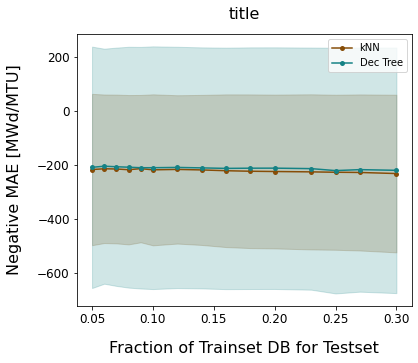

In [40]:
plot_learncurves('burnup', 'title')

<Figure size 432x288 with 0 Axes>

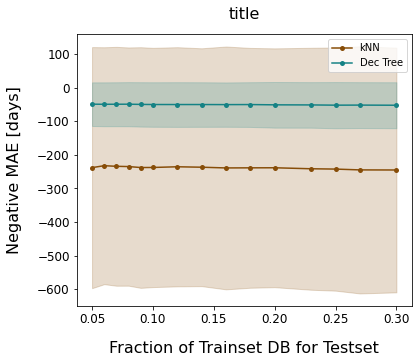

In [42]:
plot_learncurves('cooling', 'title')

## Mimic MLL

In [10]:
def rxtr_metrics(df, d, knn, dtr):
    dfmetric = 'Accuracy'
    dfstd = 'Acc Std'
    errname = 'AbsError'    
    for en_list in ['31', '_auto', '113']:
        for a, A, alg in zip(['knn', 'dtree'], ['kNN', 'DTree'], [knn, dtr]):
            df.loc[d, (a+en_list, dfmetric)] = balanced_accuracy_score(alg[en_list]['TrueY'], alg[en_list][A], adjusted=True)
            df.loc[d, (a+en_list, dfstd)] = alg[en_list][errname].std()
    return df

def reg_metrics(df, d, knn, dtr):
    dfmetric = 'Neg MAE'
    dfstd = 'MAE Std'
    errname = 'AbsError'    
    for en_list in ['31', '_auto', '113']:
        for a, A, alg in zip(['knn', 'dtree'], ['kNN', 'DTree'], [knn, dtr]):
            df.loc[d, (a+en_list, dfmetric)] = -mean_absolute_error(alg[en_list]['TrueY'], alg[en_list][A])
            df.loc[d, (a+en_list, dfstd)] = alg[en_list][errname].std()
    return df

In [11]:
extra_dir = 'test_0.067_only/'
results = {}
for p in pred:
    if p == 'reactor':
        levels = [algcol, scrcol]
    else: 
        levels = [algcol, errcol]
    df = pd.DataFrame(index=dets, columns=pd.MultiIndex.from_product(levels, names=["Algorithm", "Metric"]))
    for d in dets:
        learn_path = learn_gam + extra_dir
        knncsv = p + '_knn' + tfrac + d + csv_end
        dtrcsv = p + '_dtree' + tfrac + d + csv_end
        if 'nuc' in d or 'act' in d:
            if d == 'act4/9':
                knncsv = p + '_knn' + tfrac + 'act4' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act4' + csv_end
                knn31 = pd.read_csv(learn_path + 'act4/' + knncsv).drop(columns='Unnamed: 0')
                dtr31 = pd.read_csv(learn_path + 'act4/' + dtrcsv).drop(columns='Unnamed: 0')
                knncsv = p + '_knn' + tfrac + 'act9' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act9' + csv_end
                ##### applying act9 to auto, although this isn't accurate #####
                knn_auto = knn113 = pd.read_csv(learn_path + 'act9/' + knncsv).drop(columns='Unnamed: 0')
                dtr_auto = dtr113 = pd.read_csv(learn_path + 'act9/' + dtrcsv).drop(columns='Unnamed: 0')
            else:
                if 'nuc' in d:
                    learn_path = learn_nuc + extra_dir
                knn_auto = knn31 = knn113 = pd.read_csv(learn_path + d + '/' + knncsv).drop(columns='Unnamed: 0')
                dtr_auto = dtr31 = dtr113 = pd.read_csv(learn_path + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        else:
            knn_auto = pd.read_csv(learn_path + 'auto/' + knncsv).drop(columns='Unnamed: 0')
            dtr_auto = pd.read_csv(learn_path + 'auto/' + dtrcsv).drop(columns='Unnamed: 0')
            knn31 = pd.read_csv(learn_path + 'n31/' + knncsv).drop(columns='Unnamed: 0')
            dtr31 = pd.read_csv(learn_path + 'n31/' + dtrcsv).drop(columns='Unnamed: 0')
            knn113 = pd.read_csv(learn_path + 'n113/' + knncsv).drop(columns='Unnamed: 0')
            dtr113 = pd.read_csv(learn_path + 'n113/' + dtrcsv).drop(columns='Unnamed: 0')
        
        # Error Calcs
        knn = {'31' : knn31, '_auto' : knn_auto, '113' : knn113}
        dtr = {'31' : dtr31, '_auto' : dtr_auto, '113' : dtr113}
        if p == 'reactor':        
            df = rxtr_metrics(df, d, knn, dtr)
        else:
            df = reg_metrics(df, d, knn, dtr)
    results[p] = df

In [ ]:
results['reactor']

# Plotting

In [12]:
def plot_curves(pred_param, title, plotdf):
    plt.clf()
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        ax.set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        ax.set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
    c = ['LBrwn', 'LTeal', 'MBrwn', 'MTeal', 'DBrwn', 'DTeal']
    lbl = ['kNN Auto', 'Dec Tree Auto', 'kNN 31', 'Dec Tree 31', 'kNN 113', 'Dec Tree 113']
    for i, alg in enumerate(algcol):
        y = np.array(plotdf[alg][metric], dtype=float)
        sd = np.array(plotdf[alg][std], dtype=float)
        ax.plot(x, y, 'o-', color=colors[c[i]], mew=0, ms=5, label=lbl[i])
        ax.fill_between(x, y - sd, y + sd, color=colors[c[i]], alpha=0.2)
    
    ax.tick_params(labelsize=12)
    h,l = ax.get_legend_handles_labels()
    #handles = [h[5], h[2], h[3], h[0], h[4], h[1]]
    #labels = [l[5], l[2], l[3], l[0], l[4], l[1]]
    #ax.legend(handles,labels,loc='best')
    ax.legend(loc='best')
    
    #if pred_param == 'reactor':
    #    ax.set_ylim(0.7, top=1.03)
    #elif pred_param == 'burnup':
    #    ax.set_ylim(-1200, top=-100)
    #elif pred_param == 'enrichment':
    #    ax.set_ylim(None, top=0.1)
    #else:
    #    ax.set_ylim(-300, top=30)
    plt.show()

<Figure size 432x288 with 0 Axes>

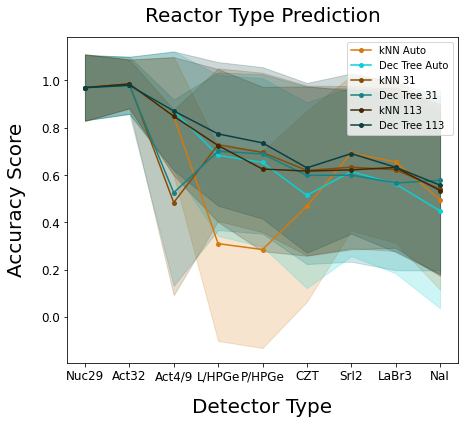

In [13]:
pred_param = 'reactor'
plot_curves(pred_param, 'Reactor Type Prediction', results[pred_param])

<Figure size 432x288 with 0 Axes>

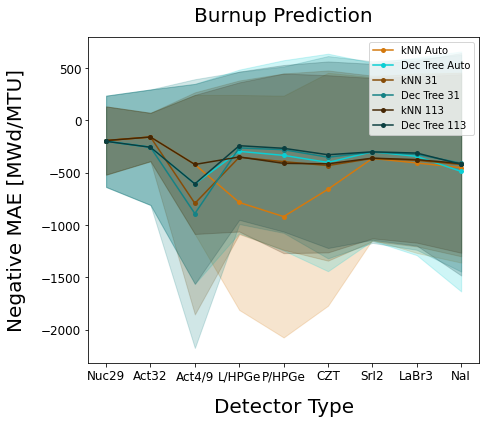

In [14]:
pred_param = 'burnup'
plot_curves(pred_param, 'Burnup Prediction', results[pred_param])

<Figure size 432x288 with 0 Axes>

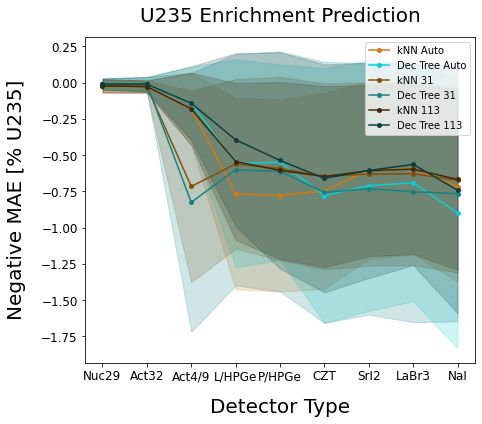

In [15]:
pred_param = 'enrichment'
plot_curves(pred_param, 'U235 Enrichment Prediction', results[pred_param])

<Figure size 432x288 with 0 Axes>

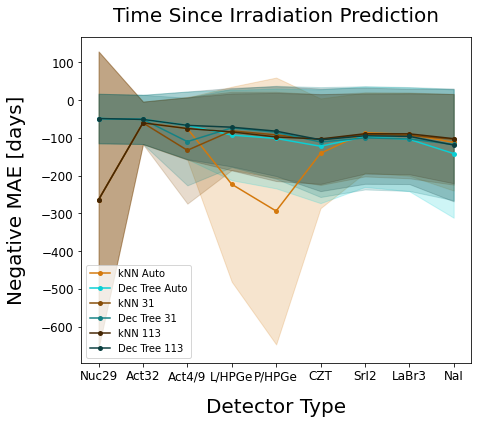

In [16]:
pred_param = 'cooling'
plot_curves(pred_param, 'Time Since Irradiation Prediction', results[pred_param])